# Imaging observations of HL Tau and an AGN model in the L and N bands

The purpose of this notebook is to show how to use a FITS image as input to create a `Source` object for imaging observations with METIS. For L-band we will work with an ALMA 233 GHz image of HL Tau, pretending that this is the structure of the object in the mid-infrared.  For the N-band, we will use a simulation of an AGN.

In [1]:
import numpy as np
from astropy.io import fits
from astropy import units as u
from astropy.wcs import WCS

In [2]:
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

In [3]:
import scopesim as sim
sim.bug_report()

# Edit this path if you have a custom install directory, otherwise comment it out. [For ReadTheDocs only]
sim.rc.__config__["!SIM.file.local_packages_path"] = "../../../"

Python:
3.11.4 | packaged by Anaconda, Inc. | (main, Jul  5 2023, 13:38:37) [MSC v.1916 64 bit (AMD64)]

Installed Python packages:
           anisocado: 0.3.0
         astar-utils: 0.2.3a0
             astropy: 5.3.4
      beautifulsoup4: 4.12.2
            docutils: 0.19
               httpx: 0.23.3
                lxml: 4.9.4
          matplotlib: 3.8.0
      more-itertools: 10.1.0
               numpy: 1.26.3
               pooch: 1.7.0
              pyyaml: 6.0.1
               scipy: 1.11.4
            scopesim: 0.8.2
       scopesim_data: could not be loaded.
  scopesim_templates: 0.5.1
         skycalc_ipy: 0.4.0
             synphot: 1.2.1
                tqdm: 4.66.1

Installed IRDB packages:

Operating System info:
   System: Windows
  Release: 10
  Version: 10.0.22631
  Machine: AMD64


To simulate observations with METIS, the instrument packages for METIS, the ELT, and Armazones are required. The packages are downloaded from the server and installed into sub-directory `inst_pkgs` in the current working directory. If you have not got the packages yet, uncomment the following cell.

In [4]:
# sim.download_package(['METIS', 'ELT', 'Armazones'])

This notebook uses two example files that can be downloaded from our server. If you already have these files, make sure that they are located in the current working directory. You can then skip the next cell.

In [5]:
sim.download_example_data(["HL_Tau_prep_for_Scopesim.fits", "AGN_uc0890_image_l12_i090_p000.fits"])

[WindowsPath('C:/Users/ghost/Desktop/PhD/irdb/METIS/docs/example_notebooks/HL_Tau_prep_for_Scopesim.fits'),
 WindowsPath('C:/Users/ghost/Desktop/PhD/irdb/METIS/docs/example_notebooks/AGN_uc0890_image_l12_i090_p000.fits')]

## Creating a source object from an image

The image that we use for the L-band is `HL_Tau_prep_for_Scopesim.fits`. This has been derived from `HLTau_B6cont_mscale_ap.image.fits`, which was retrieved from the ESO Science archive. The main step in preparing this file was a rescaling of the image values such that they directly represent flux in Jy per pixel (the flux scale was arbitrarily set such that the average over the first ring corresponds to 0.01 Jy/arcsec2). The image has a pixel scale of 5 mas, which was retained.  

In [6]:
input_hdul = fits.open("HL_Tau_prep_for_Scopesim.fits")

The header contains the information necessary for Scopesim, a WCS and the `BUNIT` keyword that gives the units of the pixel values. Scopesim mainly needs the `CDELT` keywords, which contain the pixel scale of the input image. The reference coordinates `CRVAL` have been set to zero as other values may confuse Scopesim at this stage.

In [7]:
input_hdul[1].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1600                                                  
NAXIS2  =                 1600                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =                801.0 / Pixel coordinate of reference point            
CRPIX2  =                801.0 / Pixel coordinate of reference point            
CDELT1  =  -1.388888888889E-06 / [deg] Coordinate increment at reference point  
CDELT2  =   1.388888888889E-06 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'             

There are several ways to instantiate a `Source` object in ScopeSim. In the present case, we provide an image (given as a FITS `HDU`). The header keyword `BUNIT` gives the units of the pixel values.

In [8]:
src = sim.Source(image_hdu=input_hdul[1])

## L-band observations of the source

The source as defined above could be observed in any waveband -- we start in the L-band. The configuration is defined by instantiating a `UserCommands` object:

In [9]:
cmd_l = sim.UserCommands(use_instrument="METIS", set_modes=["img_lm"])

The default filter is L':

In [10]:
cmd_l["!OBS.filter_name"]

'Lp'

A different filter could be selected by setting this parameter to a different value. Parameters can also be set by giving a properties dictionary, e.g:
```python
cmd_l = sim.UserCommands(use_instrument="METIS", set_modes=["img_lm"],
                         properties={"!OBS.filter_name": "Mp", "!OBS.exptime": 100.})
```
We shall stick to the L' filter here, and set the exposure time directly in the `readout()` commands later.

We will now build the `OpticalTrain` (which includes atmosphere, telescope and instrument) and `observe` the source. 

In [11]:
metis_l = sim.OpticalTrain(cmd_l)

In [12]:
metis_l.observe(src, update=True)

 FOVs: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.05s/it]
 Image Plane effects: 0it [00:00, ?it/s]


The `observe` command creates the ideal image that arrives at the detector focal plane and stores it as
```python
metis_l.image_planes[0]
```
This is an HDU object, the image is accessed by appending `.data`.

   Photon noise and detector noise are created by the `readout` command, which can be applied several times. In this example we read out with two different exposure times. The exposure time is split automatically into DITs such that the detector is not saturated.

In [13]:
result_10 = metis_l.readout(exptime=10., dit=None, ndit=None)[0]
print("----")
result_100 = metis_l.readout(exptime=100., dit=None, ndit=None)[0]

astar.scopesim.effects.electronic - Requested exposure time: 10.000 s
astar.scopesim.effects.electronic - Required DIT without saturation: 0.285 s
astar.scopesim.effects.electronic - Exposure parameters: DIT = 0.278 s, NDIT = 36
astar.scopesim.effects.electronic - Total exposure time: 10.000 s
astar.scopesim.detector.detector_array - Extracting from 1 detectors...
astar.scopesim.effects.electronic - Requested exposure time: 10.000 s
astar.scopesim.effects.electronic - Required DIT without saturation: 0.285 s
astar.scopesim.effects.electronic - Exposure parameters: DIT = 0.278 s, NDIT = 36
astar.scopesim.effects.electronic - Total exposure time: 10.000 s
----
astar.scopesim.effects.electronic - Requested exposure time: 100.000 s
astar.scopesim.effects.electronic - Required DIT without saturation: 0.285 s
astar.scopesim.effects.electronic - Exposure parameters: DIT = 0.284 s, NDIT = 352
astar.scopesim.effects.electronic - Total exposure time: 100.000 s
astar.scopesim.detector.detector_ar

`readout` creates a list of HDU lists (a list of multi-extension fits files). In this example the list contains a single HDU list, which we have already extracted by adding `[0]` above. The detector image is in the first extension of the HDU list. In the following cells we display (sections of) the detector images, with the input image for comparison, and then save the results to fits files.

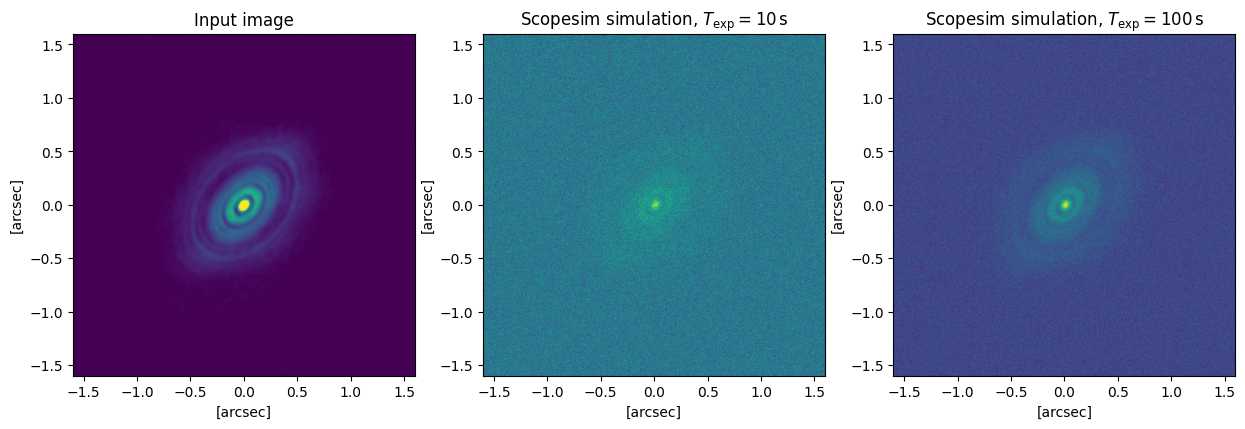

In [14]:
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(input_hdul[1].data[520:1160, 483:1123], origin='lower', vmin=0, vmax=5e-7,
          extent=(-1.6, 1.6, -1.6, 1.6))
plt.xlabel("[arcsec]")
plt.ylabel("[arcsec]")
plt.title("Input image")
plt.subplot(132)
plt.imshow(result_10[1].data[768:1352, 732:1316], origin='lower', extent=(-1.6, 1.6, -1.6, 1.6))
plt.xlabel("[arcsec]")
plt.ylabel("[arcsec]")
plt.title(r"Scopesim simulation, $T_\mathrm{exp} = 10\,\mathrm{s}$")
plt.subplot(133)
plt.imshow(result_100[1].data[768:1352, 732:1316], origin='lower', extent=(-1.6, 1.6, -1.6, 1.6))
plt.xlabel("[arcsec]")
plt.ylabel("[arcsec]")
plt.title(r"Scopesim simulation, $T_\mathrm{exp} = 100\,\mathrm{s}$");

In [15]:
result_10.writeto("hl_tau_img_l_10s.fits", overwrite=True)
result_100.writeto("hl_tau_img_l_100s.fits", overwrite=True)

## N-band observation of the source

First we load the image, here an image from a simulation of an AGN with 1% Eddington ratio, observed edge-on at 12 micron.

In [16]:
input_hdul = fits.open("AGN_uc0890_image_l12_i090_p000.fits")

Let's have a look at the image's header to see if it is complete for ScopeSim:

In [17]:
input_hdul[0].header

SIMPLE  =                    T /image conforms to FITS standard                 
BITPIX  =                  -64 /bits per data value                             
NAXIS   =                    2 /number of axes                                  
NAXIS1  =                  512 /                                                
NAXIS2  =                  512 /                                                
EXTEND  =                    T /file may contain extensions                     
LAMBDA1 =  1.2000000000000E-05                                                  
DIST    =  4.5000000000000E+01                                                  
TAG1    =  9.0000000000000E+01                                                  
PIXSIZE =  5.0115106629080E-04                                                  
BTYPE   = 'Intensity'                                                           
BUNIT   = 'JY/PIXEL'                                                            
CDELT1  =  1.3920862952549E-

It is complete, but the pixel scale is very small, since the image was created for VLTI observations. We modify the pixel scale and also adjust the total flux to represent a real object, in this case a powerful AGN with a total extent of about 1" and a total flux of about 1 Jy.

In [18]:
input_hdul[0].header["CDELT1"]=1.39e-6
input_hdul[0].header["CDELT2"]=1.39e-6 ## increase pixel scaling by factor of 10
input_hdul[0].data*=50 ## sets total flux to ca. 1 Jy

Let us confirm that the total flux is now about 1 Jy:

In [19]:
np.sum(input_hdul[0].data)

1.1967762598998202

We now set up a new source object. Unfortunately, the value 'JY/PIXEL' of the header keyword `BUNIT` is not compliant with the FITS standard and is not understood by Scopesim. We could simply change it to the compliant form 'Jy'. Alternatively, the `flux` parameter can be used to stipulate that an image value of 1 corresponds to 1 Jy. Implicitly, this assigns a spectrum that has a constant value of $f_{\nu}$ to each pixel.

In [20]:
src = sim.Source(image_hdu=input_hdul[0], flux=1*u.Jy)

We set up the instrument for N-band imaging, the total requested exposure time is set to 3600 s.

In [21]:
cmd_n = sim.UserCommands(use_instrument='METIS', set_modes=['img_n'], 
                        properties={"!OBS.exptime": 3600})

The default filter is N2. As before it could be changed by modifying the configuration keyword

In [22]:
cmd_n['!OBS.filter_name']

'N2'

The instrument itself (the `OpticalTrain`), including atmosphere and telescope, is built by

In [23]:
metis_n = sim.OpticalTrain(cmd_n)

The list of "effects" in the `OpticalTrain` can be accessed by `metis_n.effects` (the method `show_in_notebook` adds some eye candy for display in this jupyter notebook). The effects that are actually applied are those with `included=True`, the others are ignored. Note that there are effects that serve the same purpose albeit in different ways. For example, both `armazones_atmo_skycalc_ter_curve` and `armazones_atmo_default_ter_curve` provide atmospheric absorption and emission. The first effect downloads the data from ESO's skycalc server; the second effect uses default data included in the instrument package. 

In [24]:
metis_n.effects.show_in_notebook()

idx,element,name,class,included
0,armazones,skycalc_atmosphere,SkycalcTERCurve,True
1,ELT,telescope_reflection,SurfaceList,True
2,METIS,common_fore_optics,SurfaceList,True
3,METIS,adc_wheel : [False],ADCWheel,False
4,METIS,slit_wheel : [False],SlitWheel,False
5,METIS,cold_stop,PupilTransmission,True
6,METIS,common_fits_keywords,ExtraFitsKeywords,True
7,METIS_IMG_N,img_n_optics,SurfaceList,True
8,METIS_IMG_N,filter_wheel : [N2],FilterWheel,True
9,METIS_IMG_N,nd_filter_wheel : [open],FilterWheel,True


We can now "observe" the source. As before, this command creates the ideal image just in front of the detector.

In [25]:
metis_n.observe(src, update=True)

 FOVs: 100%|█████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.73s/it]
 Image Plane effects: 0it [00:00, ?it/s]


The N band configuration of METIS includes a detector effect `ChopNodCombiner`. By default, this effect is switched off so that the readout corresponds to a staring observation, which should be sufficient for most science applications. 
When the effect is switched on it creates four detector images with chopping and nodding offsets and combines them into a chop-nod image with positive and negative beam images. This corresponds to the primary data product of the METIS data reduction pipeline. 
The default pattern is perpendicular chopping and nodding with

In [26]:
metis_n['chop_nod'].include = True
print("Chopping:", metis_n.cmds['!OBS.chop_offsets'])
print("Nodding: ", metis_n.cmds['!OBS.nod_offsets'])

Chopping: [3, 0]
Nodding:  [0, 3]


The exposure time given to the `readout()` method is the integration time on one position. With `exptime=3600`, we therefore get a total integration time of 14400 s:

In [27]:
outhdul_perpendicular = metis_n.readout(exptime=3600, dit=None, ndit=None)[0]

astar.scopesim.effects.electronic - Requested exposure time: 3600.000 s
astar.scopesim.effects.electronic - Required DIT without saturation: 0.017 s
astar.scopesim.effects.electronic - Exposure parameters: DIT = 0.017 s, NDIT = 218074
astar.scopesim.effects.electronic - Total exposure time: 3600.000 s
astar.scopesim.detector.detector_array - Extracting from 1 detectors...
astar.scopesim.effects.electronic - Requested exposure time: 3600.000 s
astar.scopesim.effects.electronic - Required DIT without saturation: 0.017 s
astar.scopesim.effects.electronic - Exposure parameters: DIT = 0.017 s, NDIT = 218074
astar.scopesim.effects.electronic - Total exposure time: 3600.000 s


In [28]:
ndit = metis_n.cmds['!OBS.ndit']
dit = metis_n.cmds['!OBS.dit']
outhdul_perpendicular[0].header['DIT'] = dit
outhdul_perpendicular[0].header['NDIT'] = ndit * 4
outhdul_perpendicular[0].header['EXPTIME'] = 4 * dit * ndit
outhdul_perpendicular.writeto('agn_er01_90deg_n_img_perpendicular.fits', overwrite=True)

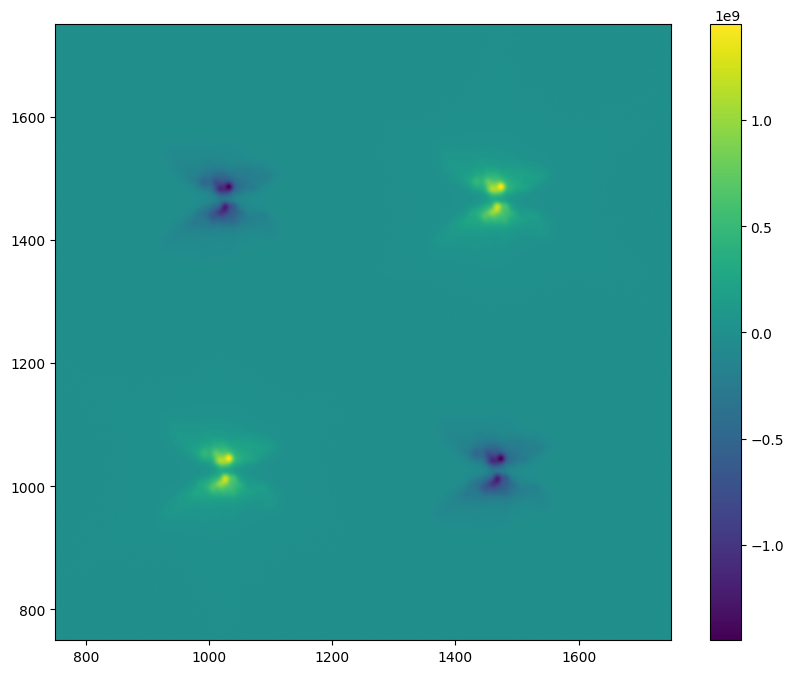

In [29]:
fig = plt.figure(figsize=(10, 8))
plt.imshow(outhdul_perpendicular[1].data[750:1750, 750:1750], origin='lower', extent=(750, 1750, 750, 1750))
plt.colorbar();

The following cell combines the four beams into a single image. The chop/nod offsets were 3 arcsec, the N-band pixel scale is 6.79 mas.

In [30]:
image = outhdul_perpendicular[1].data
shift = int(3 / 0.00679)
xmin, xmax, ymin, ymax = 823, 1232, 853, 1253
beam_1 = image[ymin:ymax, xmin:xmax]
beam_2 = image[ymin:ymax, xmin+shift:xmax+shift]
beam_3 = image[ymin+shift:ymax+shift, xmin:xmax]
beam_4 = image[ymin+shift:ymax+shift, xmin+shift:xmax+shift]
final_img = beam_1 - beam_2 - beam_3 + beam_4

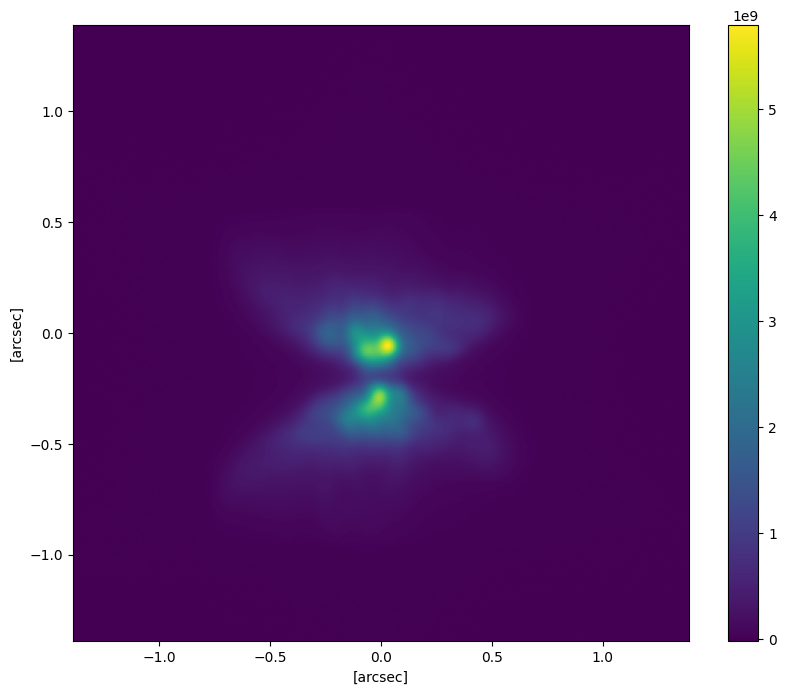

In [31]:
plt.figure(figsize=(10, 8))
hw_arcsec = (xmax - xmin)/2 * 0.00679
plt.imshow(final_img, origin='lower', extent=(-hw_arcsec, hw_arcsec, -hw_arcsec, hw_arcsec))
plt.xlabel("[arcsec]")
plt.ylabel("[arcsec]")
plt.colorbar();

In [32]:
final_wcs = WCS(naxis=2)
final_wcs.wcs.ctype = ['LINEAR', 'LINEAR']
final_wcs.wcs.crpix = [(final_img.shape[1] - 1)/2, (final_img.shape[0] - 1)/2]
final_wcs.wcs.crval = [0., 0.]
final_wcs.wcs.cdelt = [0.00679, 0.00679] ## this is the METIS detector plate scale in arcseconds
final_wcs.wcs.cunit = ['arcsec', 'arcsec']
final_hdr = final_wcs.to_header()
final_hdr['EXPTIME'] = 4 * dit * ndit
fits.writeto("agn_er01_90deg_n_img_reconstructed.fits", data=final_img, header=final_hdr, overwrite=True)